In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../opencv_helper")))
from opencv_helper import helper

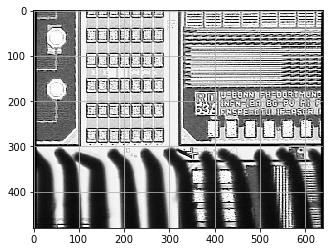

In [2]:
img_name = '../inputs/train.png'
origin = cv2.imread(img_name)
img = cv2.cvtColor(origin, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')
plt.grid()
plt.show()

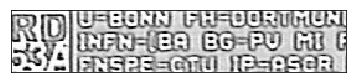

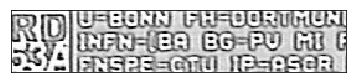

In [4]:
template = img[180:230, 360:630]
helper.show_img(template)
cv2.imwrite("RD53_template_less.png", template)


In [4]:
sift = cv2.xfeatures2d.SIFT_create()

In [10]:
img1 = template.copy() # query image
img2 = img.copy()      # traing image

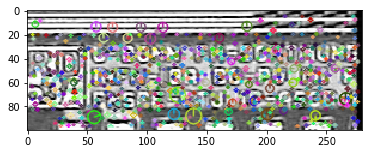

In [6]:
kp1, des1 = sift.detectAndCompute(img1, None)
img1_cp = img1.copy()
img1_cp = cv2.drawKeypoints(img1_cp, kp1, img1_cp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img1_cp, cmap='gray')

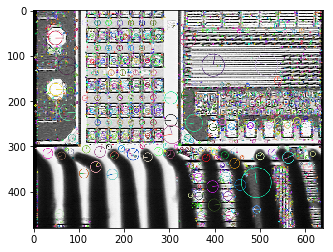

In [7]:
kp2, des2 = sift.detectAndCompute(img2, None)
img2_cp = img2.copy()
img2_cp = cv2.drawKeypoints(img2_cp, kp2, img2_cp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img2_cp, cmap='gray')

In [11]:
img3, img2_cp = helper.SIFT_obj_identify(img1, img2)

[[[ 360.00015259  180.00001526]]

 [[ 360.00027466  229.00053406]]

 [[ 629.00012207  228.99996948]]

 [[ 629.          179.9992981 ]]]


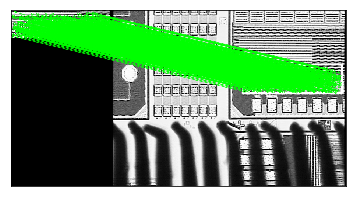

In [6]:
helper.show_img(img3)

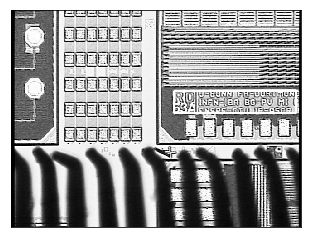

In [12]:
helper.show_img(img2_cp)

[[[ 380.79678345  206.05651855]]

 [[ 381.34490967  254.46551514]]

 [[ 649.99121094  254.4569397 ]]

 [[ 650.23925781  206.22499084]]]


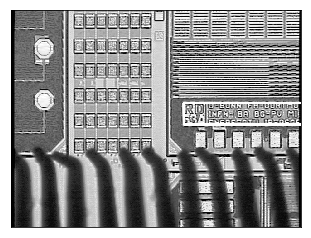

In [13]:
img4 = cv2.imread('../inputs/template.png', 0)
helper.show_img(helper.SIFT_obj_identify(img1, cv2.equalizeHist(img4))[1])

[[[ 363.54116821  177.4630127 ]]

 [[ 364.63796997  226.39491272]]

 [[ 633.11914062  226.45932007]]

 [[ 633.18811035  177.54988098]]]


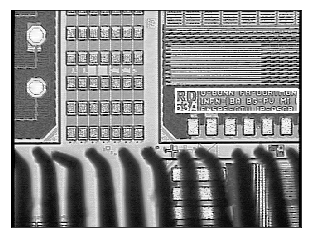

In [14]:
img5 = cv2.imread('../inputs/test.png', 0)
helper.show_img(helper.SIFT_obj_identify(img1, cv2.equalizeHist(img5))[1])

In [13]:
def SIFT_obj_identify(img1, img2):
    """
    Locate img1 from img2 using SIFT feature extraction and KNN matching alg.
    :param img1: query image in gray scale
    :param img2: train image in gray scale
    :return: img3, a combination of img1 and img2
    """
    img1_cp = img1.copy()
    img2_cp = img2.copy()
    sift = cv2.xfeatures2d.SIFT_create()

    # find the key points and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1_cp, None)
    kp2, des2 = sift.detectAndCompute(img2_cp, None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    # store all the good matches as per Lowe's ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    print("good candidates: ", len(good))
    MIN_MATCH_COUNT = 10
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()

        h, w = img1_cp.shape
        pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, M)
        print(dst)

        img2_cp = cv2.polylines(img2_cp, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

    else:
        print("Not enough matches are found - %d/%d".format(len(good), MIN_MATCH_COUNT))
        matchesMask = None

    draw_params = dict(matchColor=(0, 255, 0),
                       singlePointColor=None,
                       matchesMask=matchesMask,
                       flags=2)
    img3 = cv2.drawMatches(img1_cp, kp1, img2_cp, kp2, good, None, **draw_params)
    return img3, img2_cp

In [15]:
plt.imshow(SIFT_obj_identify(img1, cv2.equalizeHist(img5))[1], cmap="gray"), plt.show

NameError: name 'SIFT_obj_identify' is not defined